# Clustering

In [76]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [77]:
# Load the data
df = pd.read_csv('Global_Music_Streaming_Listener_Preferences.csv')
df.head()

,User_ID,Age,Country,Streaming Platform,Top Genre,Minutes Streamed Per Day,Number of Songs Liked,Most Played Artist,Subscription Type,Listening Time (Morning/Afternoon/Night),Discover Weekly Engagement (%),Repeat Song Rate (%)
0,U1000,34,Japan,Tidal,Reggae,295,138,Adele,Free,Afternoon,47.42,16.74
1,U1001,24,Germany,Deezer,Country,86,388,Ed Sheeran,Premium,Night,12.06,69.25
2,U1002,49,Germany,Deezer,Pop,363,368,Post Malone,Premium,Afternoon,47.19,67.38
3,U1003,55,Australia,YouTube,Reggae,348,349,Dua Lipa,Premium,Morning,31.27,76.51
4,U1004,13,Germany,Amazon Music,Reggae,30,328,Adele,Free,Night,30.68,43.41


In [78]:
# ---------------- Data Modification ----------------
df.rename(columns={
    'User ID': 'user_id',
    'Age': 'age',
    'Country': 'country',
    'Streaming Platform': 'streaming_platform',
    'Top Genre': 'top_genre',
    'Minutes Streamed Per Day': 'minutes_streamed_per_day',
    'Most Played Artist': 'most_played_artist',
    'Number of Songs Liked': 'number_of_songs_liked',
    'Subscription Type': 'subscription_type',
    'Listening Time (Morning/Afternoon/Night)': 'listening_time',
    'Discover Weekly Engagement (%)': 'discover_weekly_engagement',
    'Repeat Song Rate (%)': 'repeat_song_rate'
}, inplace=True)

developed_countries = {'Japan', 'Germany', 'Australia', 'South Korea', 'UK', 'Canada', 'USA', 'France'}
developing_countries = {'India', 'Brazil'}

# Add new column
df['country_dev_status'] = df['country'].apply(lambda x: 'developed' if x in developed_countries else 'developing')

# All features
num_all_features = [
    'age', 'minutes_streamed_per_day', 'number_of_songs_liked',
    'discover_weekly_engagement','repeat_song_rate'
]

cat_all_features = [
    'country', 'streaming_platform', 'top_genre', 'most_played_artist',
    'subscription_type', 'listening_time', 'country_dev_status'
]

In [79]:
# ---------------- Select Features ----------------
features = [
    'minutes_streamed_per_day', 
    'number_of_songs_liked',
    'discover_weekly_engagement'
] 
X = df[features].copy()

In [80]:
# ---------------- Encoding and Scaling ----------------
numeric_features = [
    'minutes_streamed_per_day', 
    'number_of_songs_liked',
    'discover_weekly_engagement'
]
categorical_features = [

]
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

In [81]:
# ----------------- Pipeline ----------------
kmeans_pipeline = Pipeline([  # 变量名改为kmeans_pipeline
    ('preprocessor', preprocessor),
    ('kmeans', KMeans(n_clusters=4, random_state=42))
])

In [82]:
# ----------------- Fit the Model ----------------
kmeans_pipeline.fit(X)

# Get cluster labels
cluster_labels = kmeans_pipeline.named_steps['kmeans'].labels_

Silhouette Score: 0.268


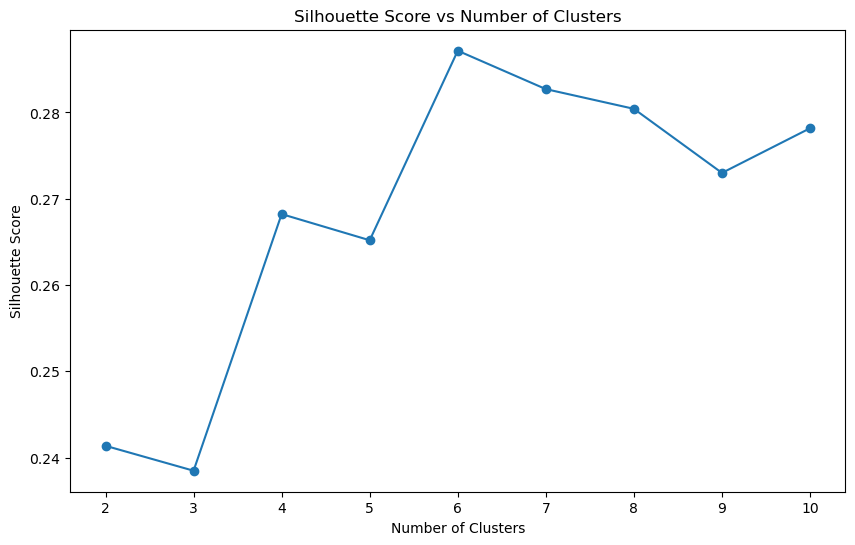

In [83]:
# ----------------- Validation ----------------
# Silhouette Score
X_processed = preprocessor.fit_transform(X)
if hasattr(X_processed, "toarray"):
    X_processed = X_processed.toarray()
sil_score = silhouette_score(X_processed, kmeans_pipeline.named_steps['kmeans'].labels_)
print(f'Silhouette Score: {sil_score:.3f}')

# Try different number of clusters
scores = []
range_n = range(2, 11)
for k in range_n:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_processed)
    scores.append(silhouette_score(X_processed, labels))

plt.figure(figsize=(10, 6))
plt.plot(range_n, scores, marker='o')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Assign cluster labels to DataFrame
df['cluster'] = cluster_labels

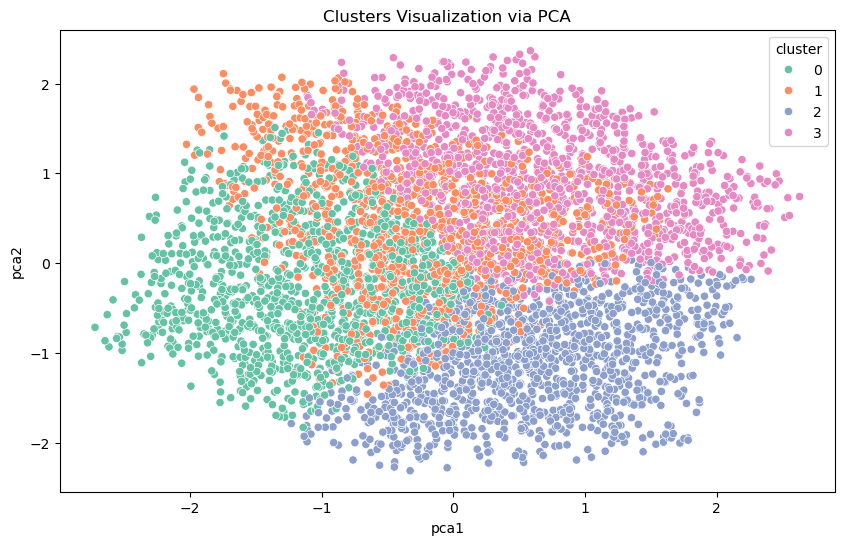

In [84]:
# ----------------- Interpret Clusters ----------------
# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)

df['pca1'] = X_pca[:, 0]
df['pca2'] = X_pca[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='pca1', y='pca2', hue='cluster', palette='Set2')
plt.title('Clusters Visualization via PCA')
plt.show()

In [85]:
# ----------------- Cluster Profiling ----------------
# Handling numeric features
cluster_profiles = df.groupby('cluster')[num_all_features].mean()
print("Cluster Feature Averages:\n", cluster_profiles)

# Handling categorical features
def top_n_modes(series, n=2):
    counts = series.value_counts(normalize=True)  # relative frequency
    top_n = counts.nlargest(n)
    return ([f"{cat} ({pct:.1%})" for cat, pct in top_n.items()])

# Apply to categorical columns
top_n_summary = df.groupby('cluster')[cat_all_features].agg(lambda x: top_n_modes(x, n=2))

# Prettify as strings for easy viewing
top_n_summary = top_n_summary.applymap(lambda x: ', '.join(x))
print(top_n_summary)

# Add count to understand size
cluster_profiles['count'] = df['cluster'].value_counts().sort_index()
print("\nCluster Sizes:\n", cluster_profiles['count'])


Cluster Feature Averages:
                age  minutes_streamed_per_day  number_of_songs_liked  \
cluster                                                               
0        36.958367                144.762449             195.915918   
1        36.363415                368.870732             120.347154   
2        36.732540                457.425397             302.453968   
3        36.603891                263.645914             387.914397   

         discover_weekly_engagement  repeat_song_rate  
cluster                                                
0                         32.778678         43.506359  
1                         68.571081         41.738675  
2                         30.627167         41.519262  
3                         68.790490         42.807136  
                                   country  \
cluster                                      
0               Brazil (11.6%), UK (11.3%)   
1         South Korea (11.5%), USA (11.1%)   
2        Australia (11.3%)

/var/folders/lw/gshrnyhd2w92_bvmsw5xd9lc0000gn/T/ipykernel_91430/4182857922.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  top_n_summary = top_n_summary.applymap(lambda x: ', '.join(x))


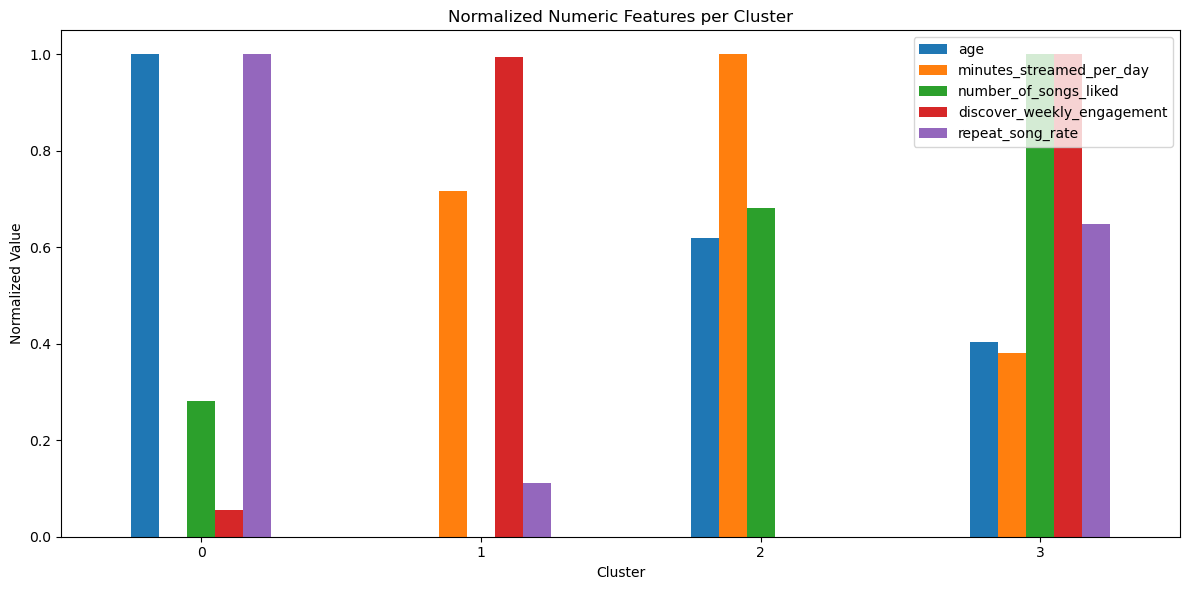

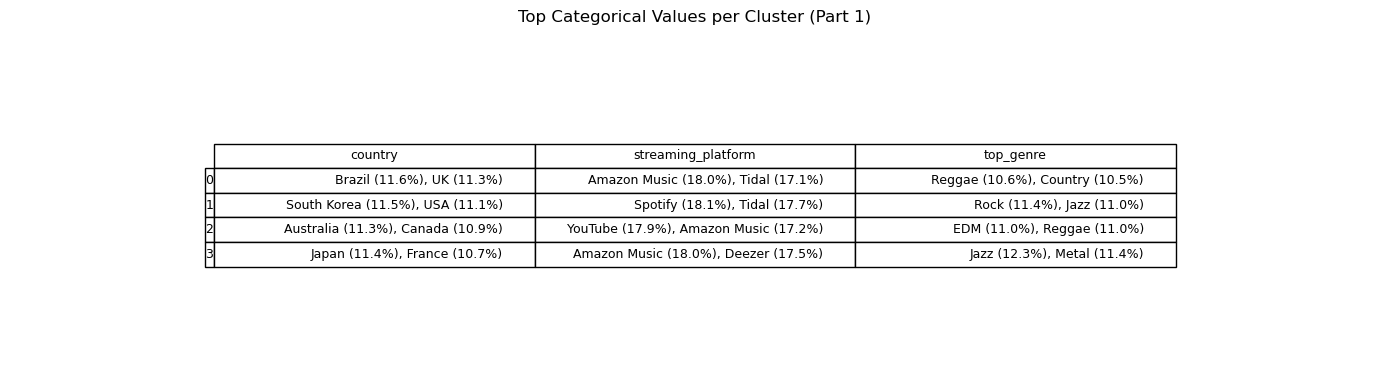

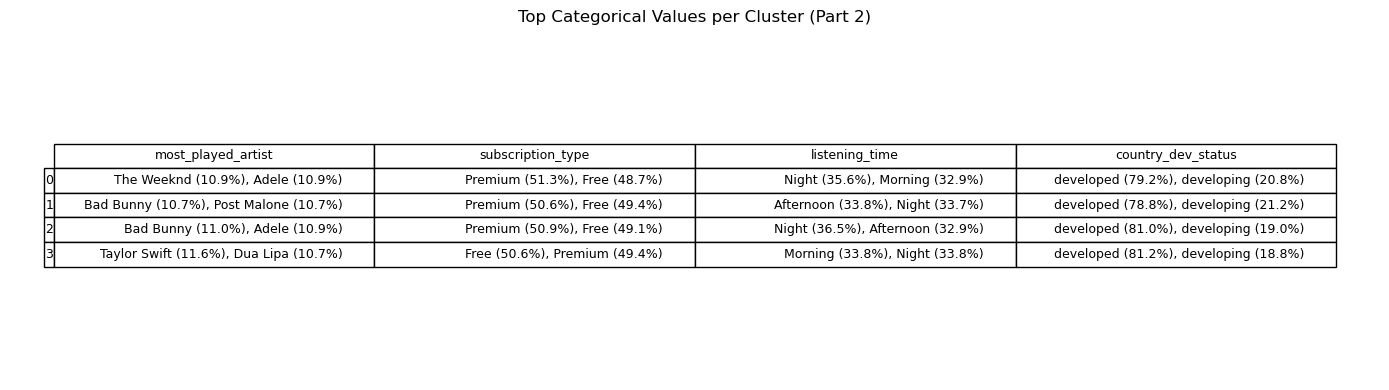

In [86]:
# ---------------- Plotting Features -----------------
cluster_profiles_no_count = cluster_profiles.drop(columns=['count'])
normalized_profiles = cluster_profiles_no_count.copy()
normalized_profiles = (normalized_profiles - normalized_profiles.min()) / (normalized_profiles.max()- normalized_profiles.min())

normalized_profiles.plot(kind='bar', figsize=(12, 6))
plt.title('Normalized Numeric Features per Cluster')
plt.ylabel('Normalized Value')
plt.xlabel('Cluster')
plt.xticks(rotation=0)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt
from pandas.plotting import table

# Split top_n_summary into two parts
half = len(top_n_summary.columns) // 2
first_half = top_n_summary.iloc[:, :half]
second_half = top_n_summary.iloc[:, half:]

# First table (part 1)
plt.figure(figsize=(14, 4))
ax1 = plt.subplot(111, frame_on=False)
ax1.xaxis.set_visible(False)
ax1.yaxis.set_visible(False)
tbl1 = table(ax1, first_half, loc='center', colWidths=[0.18]*first_half.shape[1])
tbl1.auto_set_font_size(False)
tbl1.set_fontsize(9)
tbl1.scale(1.3, 1.3)
plt.title("Top Categorical Values per Cluster (Part 1)")
plt.tight_layout()
plt.show()

# Second table (part 2)
plt.figure(figsize=(14, 4))
ax2 = plt.subplot(111, frame_on=False)
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)
tbl2 = table(ax2, second_half, loc='center', colWidths=[0.18]*second_half.shape[1])
tbl2.auto_set_font_size(False)
tbl2.set_fontsize(9)
tbl2.scale(1.3, 1.3)
plt.title("Top Categorical Values per Cluster (Part 2)")
plt.tight_layout()
plt.show()

In [87]:
# ----------------- Focused Lift Analysis ----------------
# Compute overall proportions
overall_premium_pct = (df['subscription_type'] == 'Premium').mean()
overall_developed_pct = (df['country_dev_status'] == 'developed').mean()

# Compute per-cluster proportions
premium_lift = df.groupby('cluster')['subscription_type'].apply(lambda x: (x == 'Premium').mean()) / overall_premium_pct
developed_lift = df.groupby('cluster')['country_dev_status'].apply(lambda x: (x == 'developed').mean()) / overall_developed_pct

# Combine into a DataFrame for readability
focused_lift_df = pd.DataFrame({
    'Premium Lift': premium_lift,
    'Developed Country Lift': developed_lift
})

print("\nFocused Lift Values (per cluster):")
print(focused_lift_df)


Focused Lift Values (per cluster):
         Premium Lift  Developed Country Lift
cluster                                      
0            1.014753                0.989301
1            1.000972                0.984264
2            1.006988                1.011399
3            0.978154                1.014084


In [88]:
# ----------------- Music Recommendation System -----------------
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [89]:
#选择新特征
features1 = [
    'minutes_streamed_per_day', 
    'repeat_song_rate',
    'age'
] 

In [90]:
# 创建推荐系统特征集（包含原始特征+聚类结果）
recommender_features = features1 + ['cluster']  # 使用原始特征+聚类结果作为特征

# 定义目标变量（预测音乐流派）
X_recommend = df[recommender_features].copy()
y_recommend = df['top_genre'].copy()

In [91]:
# 单独处理数值特征
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_recommend[features1])

# 合并处理后的特征
X_processed = pd.DataFrame(
    data=X_num_scaled,
    columns=features1,
    index=X_recommend.index
)
X_processed['cluster'] = X_recommend['cluster'].values  # 添加聚类结果


In [92]:
# 划分训练测试集
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_recommend, 
    test_size=0.2, 
    random_state=42,
    stratify=y_recommend  # 保持类别分布
)


In [93]:
# 构建决策树模型
dt_clf = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=20,
    class_weight='balanced',
    random_state=42
)


推荐系统性能评估:
              precision    recall  f1-score   support

   Classical       0.07      0.14      0.09        95
     Country       0.12      0.06      0.08        97
         EDM       0.07      0.06      0.06       106
     Hip-Hop       0.00      0.00      0.00        97
        Jazz       0.20      0.03      0.05       106
       Metal       0.00      0.00      0.00        98
         Pop       0.10      0.65      0.17        92
         R&B       0.10      0.02      0.03        99
      Reggae       0.00      0.00      0.00       107
        Rock       0.25      0.04      0.07       103

    accuracy                           0.09      1000
   macro avg       0.09      0.10      0.06      1000
weighted avg       0.09      0.09      0.05      1000



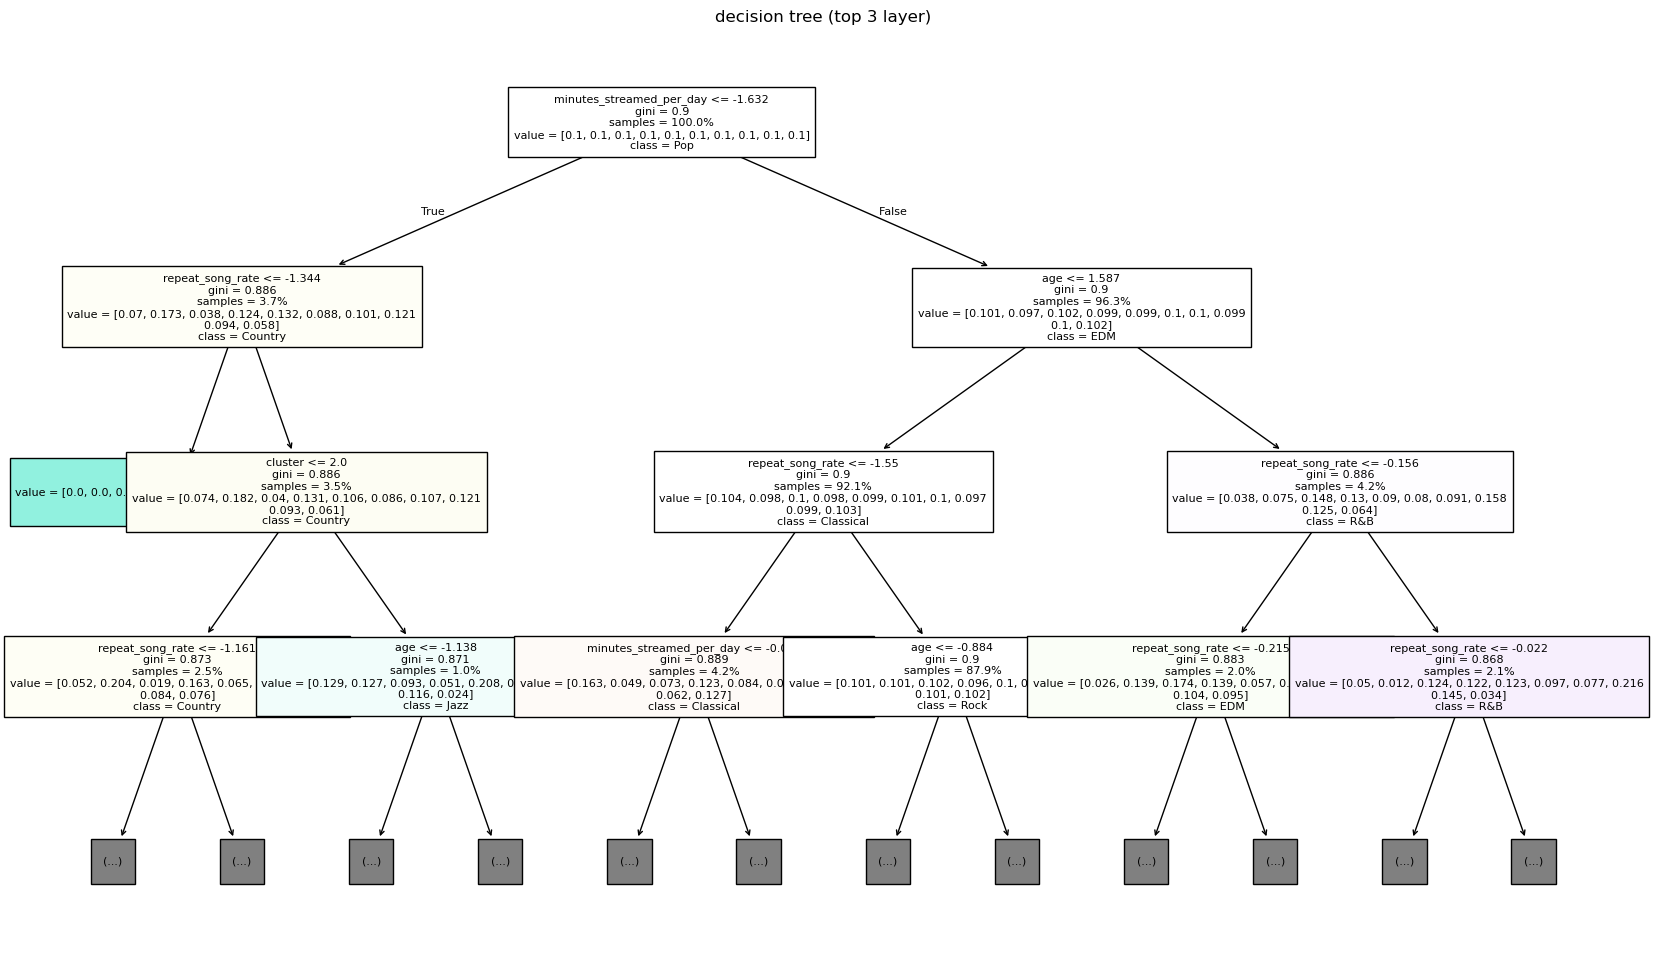

In [94]:
# 训练模型
dt_clf.fit(X_train, y_train)

# 评估模型
print("\n推荐系统性能评估:")
print(classification_report(y_test, dt_clf.predict(X_test)))

# 可视化决策树
plt.figure(figsize=(20, 12))
plot_tree(dt_clf, 
          feature_names=X_processed.columns,
          class_names=dt_clf.classes_,
          filled=True,
          proportion=True,
          max_depth=3,  # 显示前3层
          fontsize=8)
plt.title("decision tree (top 3 layer)")
plt.show()

In [95]:
# 特征重要性分析
feature_importance = pd.DataFrame({
    'feature': X_processed.columns,
    'importance': dt_clf.feature_importances_
}).sort_values('importance', ascending=False)

print("\n特征重要性排序:")
print(feature_importance)

# 示例预测
sample_user = X_processed.iloc[[100]]  # 取第一个用户
predicted_genre = dt_clf.predict(sample_user)[0]
print(f"\n示例推荐预测: 用户可能喜欢的音乐类型为 [{predicted_genre}]")


特征重要性排序:
                    feature  importance
1          repeat_song_rate    0.473248
0  minutes_streamed_per_day    0.268256
2                       age    0.153029
3                   cluster    0.105468

示例推荐预测: 用户可能喜欢的音乐类型为 [Classical]



推荐系统性能评估:
              precision    recall  f1-score   support

   Classical       0.08      0.14      0.10        95
     Country       0.07      0.03      0.04        97
         EDM       0.07      0.06      0.06       106
     Hip-Hop       0.00      0.00      0.00        97
        Jazz       0.14      0.01      0.02       106
       Metal       0.08      0.01      0.02        98
         Pop       0.10      0.65      0.17        92
         R&B       0.15      0.04      0.06        99
      Reggae       0.18      0.02      0.03       107
        Rock       0.25      0.04      0.07       103

    accuracy                           0.09      1000
   macro avg       0.11      0.10      0.06      1000
weighted avg       0.11      0.09      0.06      1000



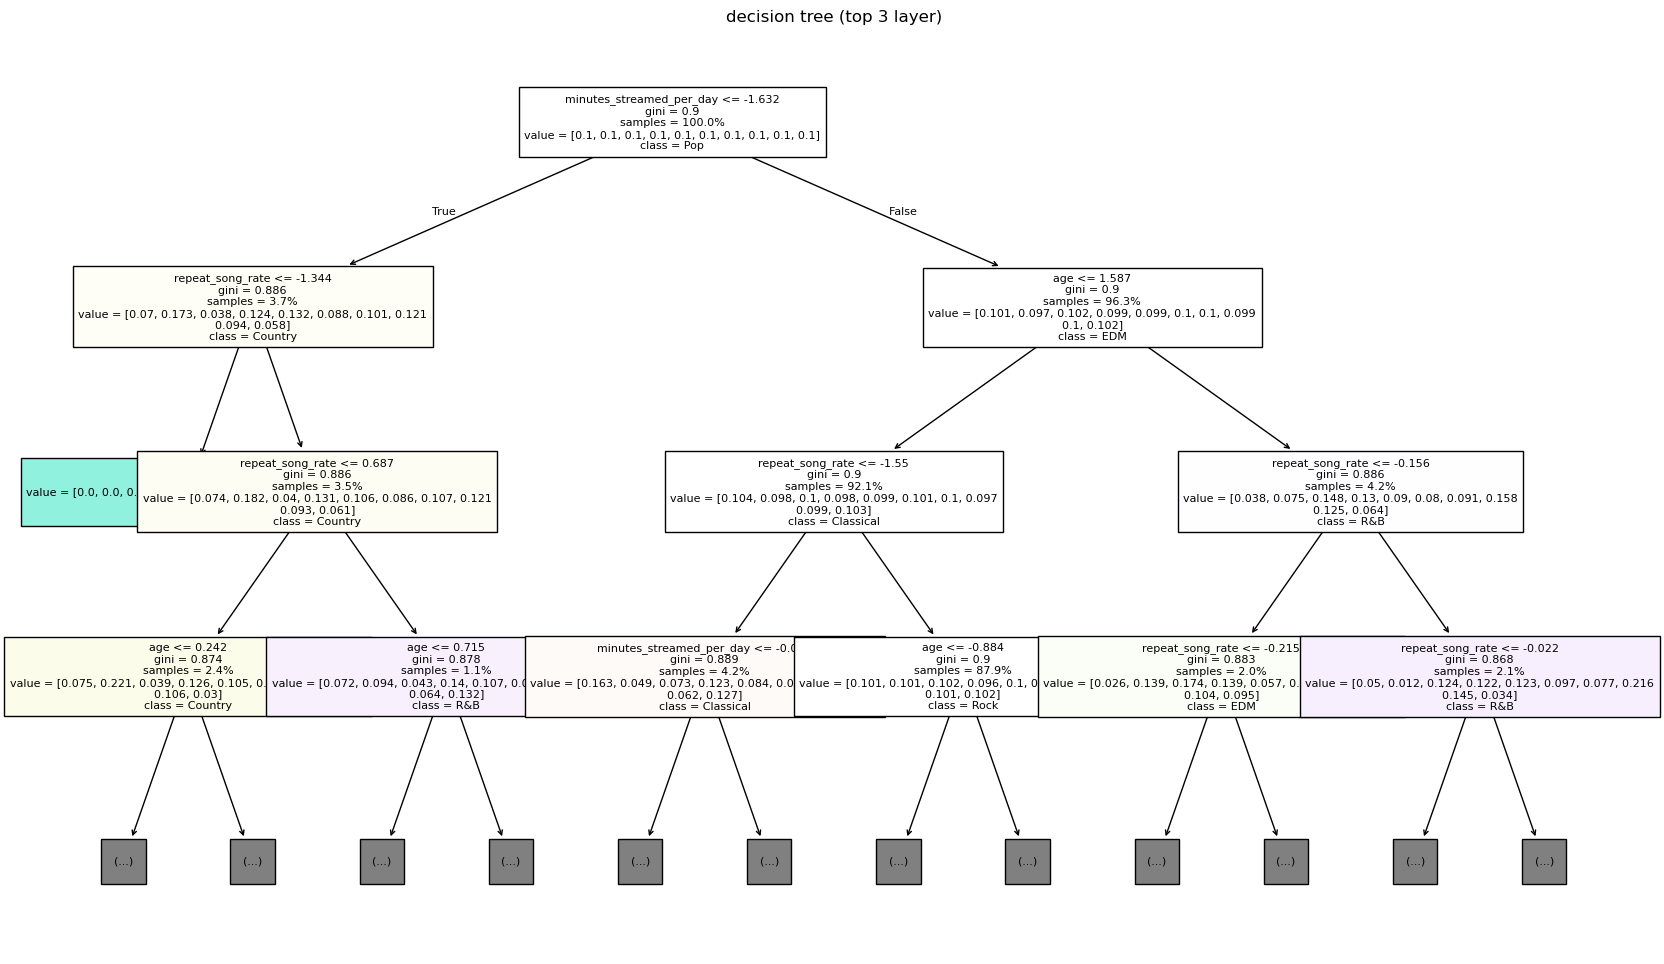


特征重要性排序:
                    feature  importance
1          repeat_song_rate    0.470730
0  minutes_streamed_per_day    0.307931
2                       age    0.221339


In [115]:
# ----------------- Music Recommendation System -----------------
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
#选择新特征
features2= [
    'minutes_streamed_per_day', 
    'repeat_song_rate',
    'age'
] 
# 定义目标变量（预测音乐流派）
X_recommend = df[recommender_features].copy()
y_recommend = df['top_genre'].copy()

# 单独处理数值特征
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_recommend[features2])

# 合并处理后的特征
X_processed = pd.DataFrame(
    data=X_num_scaled,
    columns=features2,
    index=X_recommend.index
)
# 划分训练测试集
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_recommend, 
    test_size=0.2, 
    random_state=42,
    stratify=y_recommend  # 保持类别分布
)
# 构建决策树模型
dt_clf = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=20,
    class_weight='balanced',
    random_state=42
)
# 训练模型
dt_clf.fit(X_train, y_train)

# 评估模型
print("\n推荐系统性能评估:")
print(classification_report(y_test, dt_clf.predict(X_test)))

# 可视化决策树
plt.figure(figsize=(20, 12))
plot_tree(dt_clf, 
          feature_names=X_processed.columns,
          class_names=dt_clf.classes_,
          filled=True,
          proportion=True,
          max_depth=3,  # 显示前3层
          fontsize=8)
plt.title("decision tree (top 3 layer)")
plt.show()

# 特征重要性分析
feature_importance = pd.DataFrame({
    'feature': X_processed.columns,
    'importance': dt_clf.feature_importances_
}).sort_values('importance', ascending=False)

print("\n特征重要性排序:")
print(feature_importance)


In [116]:
# ----------------- 改进的示例预测功能 ----------------
# 创建多个测试用户样本
test_users = [
    # 常规用户
    {'age': 28, 'minutes_streamed_per_day': 150, 'repeat_song_rate': 30},
    # 年轻高活跃度用户
    {'age': 18, 'minutes_streamed_per_day': 300, 'repeat_song_rate': 10},
    # 高重复收听用户
    {'age': 45, 'minutes_streamed_per_day': 90, 'repeat_song_rate': 70}
]

def predict_genre(user_data):
    """处理用户输入并预测音乐流派"""
    # 1. 创建数据框并确保特征顺序一致
    user_df = pd.DataFrame([user_data], columns=features2)
    
    # 2. 应用相同的预处理（标准化）
    # 重要：使用训练时的scaler对象而非创建新对象
    user_scaled = scaler.transform(user_df)
    
    # 3. 预测概率（不只是最终流派）
    probabilities = dt_clf.predict_proba(user_scaled)[0]
    predicted_idx = dt_clf.predict(user_scaled)[0]
    
    # 4. 获取概率最高的3个流派
    top_indices = np.argsort(probabilities)[-3:][::-1]
    top_genres = [dt_clf.classes_[i] for i in top_indices]
    top_probs = [probabilities[i] for i in top_indices]
    
    return predicted_idx, list(zip(top_genres, top_probs))

# 打印所有测试用户的预测结果
print("\n=== 音乐流派推荐测试 ===")
for i, user in enumerate(test_users):
    # 获取预测结果
    main_genre, top_choices = predict_genre(user)
    
    # 格式化输出
    print(f"\n用户 #{i+1} 特征:")
    print(f"  - 年龄: {user['age']}")
    print(f"  - 每日收听时长: {user['minutes_streamed_per_day']}分钟")
    print(f"  - 歌曲重复率: {user['repeat_song_rate']}%")
    
    print(f"\n 推荐结果:")
    print(f"  主推流派: [{main_genre}]")
    
    print(f"  备选推荐:")
    for genre, prob in top_choices:
        print(f"    • {genre}: {prob*100:.1f}%概率")


=== 音乐流派推荐测试 ===

用户 #1 特征:
  - 年龄: 28
  - 每日收听时长: 150分钟
  - 歌曲重复率: 30%

 推荐结果:
  主推流派: [Pop]
  备选推荐:
    • Pop: 11.0%概率
    • Metal: 10.4%概率
    • Rock: 10.2%概率

用户 #2 特征:
  - 年龄: 18
  - 每日收听时长: 300分钟
  - 歌曲重复率: 10%

 推荐结果:
  主推流派: [EDM]
  备选推荐:
    • EDM: 14.2%概率
    • Rock: 14.2%概率
    • Reggae: 12.5%概率

用户 #3 特征:
  - 年龄: 45
  - 每日收听时长: 90分钟
  - 歌曲重复率: 70%

 推荐结果:
  主推流派: [Pop]
  备选推荐:
    • Pop: 11.0%概率
    • Metal: 10.4%概率
    • Rock: 10.2%概率


In [96]:
# =================音乐推荐系统 =================
# --------- 1. 数据准备 ---------
rec_features = [
    'age', 'minutes_streamed_per_day', 'number_of_songs_liked',
    'discover_weekly_engagement', 'repeat_song_rate',
    'country', 'streaming_platform', 'most_played_artist',
    'subscription_type', 'listening_time', 'country_dev_status'
]  

rec_label = 'top_genre'

# Step 1: 先选择所需列
selected_cols = rec_features + [rec_label]
sub_df = df[selected_cols].copy()

# Step 2: 在当前子数据框检查列名重复
is_duplicated = sub_df.columns.duplicated()

# Step 3: 过滤重复列（当前子数据框范围）
rec_df = sub_df.loc[:, ~is_duplicated].dropna().copy()

# 验证步骤
print("最终列名:", rec_df.columns.tolist())
assert rec_df.columns.is_unique, f"重复列: {rec_df.columns[rec_df.columns.duplicated()].tolist()}"

# 安全选择列
rec_df = df[rec_features + [rec_label]].copy()
rec_df = rec_df.loc[:, ~rec_df.columns.duplicated()].dropna()

最终列名: ['age', 'minutes_streamed_per_day', 'number_of_songs_liked', 'discover_weekly_engagement', 'repeat_song_rate', 'country', 'streaming_platform', 'most_played_artist', 'subscription_type', 'listening_time', 'country_dev_status', 'top_genre']


In [97]:
# --------- 2. 特征预处理 ---------
# 定义更新后的特征列表
num_all_features = [
    'age', 'minutes_streamed_per_day', 'number_of_songs_liked',
    'discover_weekly_engagement', 'repeat_song_rate'
]

cat_all_features = [
    'country', 'streaming_platform', 'most_played_artist',
    'subscription_type', 'listening_time', 'country_dev_status'
]

rec_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_all_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_all_features)
    ],
    verbose_feature_names_out=True
)

In [98]:
# --------- 3. 构建推荐管道 ---------
X_rec = rec_df[rec_features]
y_rec = rec_df[rec_label]
X_train, X_test, y_train, y_test = train_test_split(X_rec, y_rec, test_size=0.2, random_state=42)

rec_pipeline = Pipeline([
    ('preprocessor', rec_preprocessor),
    ('classifier', DecisionTreeClassifier(
        max_depth=4,
        min_samples_split=20,
        class_weight='balanced'
    ))
])

# 训练验证
rec_pipeline.fit(X_train, y_train)
print("模型训练成功！")

模型训练成功！


In [99]:
# --------- 4. 模型评估 ---------
print("\n=== 推荐模型性能评估 ===")
y_pred = rec_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))


=== 推荐模型性能评估 ===
              precision    recall  f1-score   support

   Classical       0.08      0.01      0.02        80
     Country       0.12      0.16      0.13        99
         EDM       0.00      0.00      0.00       111
     Hip-Hop       0.09      0.06      0.07       114
        Jazz       0.00      0.00      0.00       104
       Metal       0.19      0.09      0.12        97
         Pop       0.09      0.56      0.16        80
         R&B       0.20      0.04      0.07        98
      Reggae       0.15      0.18      0.17       103
        Rock       0.10      0.07      0.08       114

    accuracy                           0.11      1000
   macro avg       0.10      0.12      0.08      1000
weighted avg       0.10      0.11      0.08      1000



In [100]:
# --------- 5. 推荐生成函数 ---------
def recommend_music(user_features):
    """
    输入格式示例：
    user_features = {
        'age': 25,
        'minutes_streamed_per_day': 120,
        'country': 'USA',
        'subscription_type': 'Premium',
        # ...其他特征
    }
    """
    # 转换为DataFrame
    input_df = pd.DataFrame([user_features])
    
    # 确保列顺序匹配
    input_df = input_df[rec_features]
    
    # 预处理和预测
    predicted_genre = rec_pipeline.predict(input_df)[0]
    probability = rec_pipeline.predict_proba(input_df).max()
    
    # 获取推荐依据
    feature_importance = rec_pipeline.named_steps['classifier'].feature_importances_
    
    return {
        'recommended_genre': predicted_genre,
        'confidence': f"{probability:.1%}",
        'top_decison_factors': sorted(
            zip(rec_pipeline[:-1].get_feature_names_out(), feature_importance),
            key=lambda x: -x[1]
        )[:3]  # 显示最重要的三个特征
    }

In [101]:
# --------- 6. 示例用法 ---------
if __name__ == "__main__":
    # 测试用户数据（需包含所有rec_features）
    test_user = {
        'age': 28,
        'minutes_streamed_per_day': 150,
        'number_of_songs_liked': 45,
        'discover_weekly_engagement': 70,
        'repeat_song_rate': 30,
        'country': 'USA',
        'streaming_platform': 'Spotify',
        'most_played_artist': 'Ed Sheeran',
        'subscription_type': 'Premium',
        'listening_time': 'Night',
        'country_dev_status': 'developed'
    }
    
    recommendation = recommend_music(test_user)
    print("\n=== 推荐结果 ===")
    print(f"推荐音乐类型: {recommendation['recommended_genre']}")
    print(f"置信度: {recommendation['confidence']}")
    print("主要决策因素:")
    for feature, importance in recommendation['top_decison_factors']:
        print(f"- {feature.split('__')[-1]}: {importance:.2%}")


=== 推荐结果 ===
推荐音乐类型: Pop
置信度: 11.2%
主要决策因素:
- repeat_song_rate: 24.49%
- number_of_songs_liked: 20.52%
- age: 20.37%


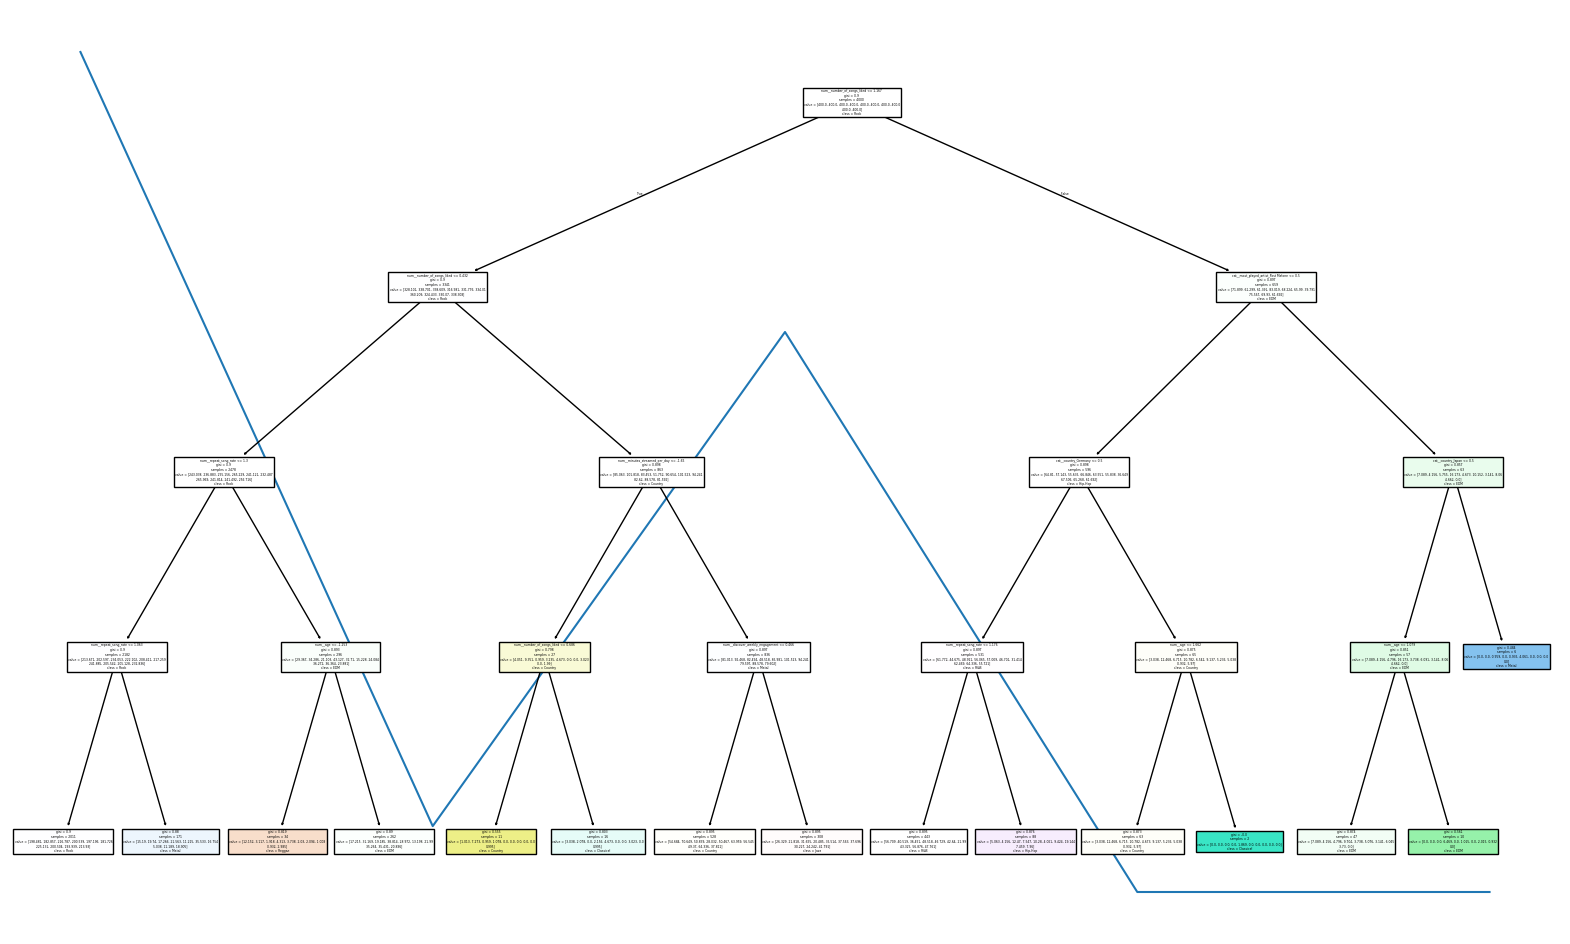

In [102]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20,12))
plot_tree(
    rec_pipeline.named_steps['classifier'],
    feature_names=rec_pipeline[:-1].get_feature_names_out(),
    class_names=rec_df[rec_label].unique(),
    filled=True
)
plt.savefig('decision_tree.png')

# 添加学习曲线评估
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(
    rec_pipeline, X_rec, y_rec, cv=5)
plt.plot(train_sizes, np.mean(test_scores, axis=1))

In [103]:
# =================音乐推荐系统（改进版）=================
# --------- 1. 数据准备与特征工程 ---------
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from category_encoders import TargetEncoder
import warnings
warnings.filterwarnings('ignore', category=UserWarning)  # 忽略目标编码的警告

# 原始特征列表
rec_features = [
    'age', 'minutes_streamed_per_day', 'number_of_songs_liked',
    'discover_weekly_engagement', 'repeat_song_rate',
    'country', 'streaming_platform', 'most_played_artist',
    'subscription_type', 'listening_time', 'country_dev_status'
]
rec_label = 'top_genre'

# 选择所需列并清理数据
selected_cols = rec_features + [rec_label]
sub_df = df[selected_cols].copy()
rec_df = sub_df.loc[:, ~sub_df.columns.duplicated()].dropna()

# 特征工程：创建新特征
rec_df['streaming_intensity'] = rec_df['minutes_streamed_per_day'] / (rec_df['age'] + 1)
rec_df['engagement_ratio'] = rec_df['number_of_songs_liked'] / (rec_df['repeat_song_rate'] + 0.1)
rec_df['daily_song_likes'] = rec_df['number_of_songs_liked'] / 30  # 假设数据覆盖30天

# 特征工程：处理国家特征（在数据准备阶段完成）
def transform_country(df):
    """将低频国家分组为'Other'"""
    df = df.copy()
    top_countries = ['USA', 'UK', 'Japan', 'Germany', 'Canada', 'Australia', 'Brazil']
    df['country'] = np.where(df['country'].isin(top_countries), df['country'], 'Other')
    return df

# 直接在数据框架上应用国家转换
rec_df = transform_country(rec_df)

# 更新特征列表（添加新特征）
new_features = [
    'age', 'minutes_streamed_per_day', 'number_of_songs_liked',
    'discover_weekly_engagement', 'repeat_song_rate',
    'streaming_intensity', 'engagement_ratio', 'daily_song_likes'
]
all_rec_features = new_features + [
    'country', 'streaming_platform', 'most_played_artist',
    'subscription_type', 'listening_time', 'country_dev_status'
]

# --------- 2. 特征预处理 ---------
# 定义数值和分类特征
num_features = new_features  # 包括新创建的特征
low_card_cat = ['subscription_type', 'listening_time', 'country_dev_status', 'country']

# 修正预处理器
rec_preprocessor = ColumnTransformer(
    transformers=[
        # 数值特征标准化
        ('num', StandardScaler(), num_features),
        
        # 低基数类别特征进行One-Hot编码
        ('low_card_cat', OneHotEncoder(handle_unknown='ignore'), low_card_cat),
        
        # 高基数特征使用目标编码
        ('artist_encoder', TargetEncoder(), ['most_played_artist']),
        ('platform_encoder', TargetEncoder(), ['streaming_platform'])
    ]
)

# --------- 3. 构建推荐管道（使用随机森林） ---------
X_rec = rec_df[all_rec_features]
y_rec = rec_df[rec_label]
X_train, X_test, y_train, y_test = train_test_split(X_rec, y_rec, test_size=0.2, random_state=42)

# 使用随机森林代替决策树
rec_pipeline = Pipeline([
    ('preprocessor', rec_preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=300,
        max_depth=15,
        min_samples_leaf=5,
        max_features='sqrt',
        class_weight='balanced_subsample',
        random_state=42,
        n_jobs=-1  # 使用所有CPU核心加速训练
    ))
])

# 训练模型
rec_pipeline.fit(X_train, y_train)
print("随机森林模型训练成功！")

# --------- 4. 模型评估 ---------
print("\n=== 推荐模型性能评估 ===")
y_pred = rec_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

# 特征重要性分析
importances = rec_pipeline.named_steps['classifier'].feature_importances_
feature_names = rec_pipeline.named_steps['preprocessor'].get_feature_names_out()

# 创建特征重要性DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("\n=== Top 10 特征重要性 ===")
print(feature_importance_df.head(10))

# --------- 5. 推荐生成函数（更新版） ---------
def recommend_music(user_features):
    """
    输入格式示例：
    user_features = {
        'age': 25,
        'minutes_streamed_per_day': 120,
        'country': 'USA',
        'subscription_type': 'Premium',
        # ...其他特征
    }
    """
    # 添加计算新特征
    age = user_features.get('age', 30)
    minutes_streamed = user_features.get('minutes_streamed_per_day', 100)
    songs_liked = user_features.get('number_of_songs_liked', 30)
    repeat_rate = user_features.get('repeat_song_rate', 20)
    
    user_features['streaming_intensity'] = minutes_streamed / (age + 1)
    user_features['engagement_ratio'] = songs_liked / (repeat_rate + 0.1)
    user_features['daily_song_likes'] = songs_liked / 30
    
    # 处理国家特征（应用相同的分组逻辑）
    top_countries = ['USA', 'UK', 'Japan', 'Germany', 'Canada', 'Australia', 'Brazil']
    country = user_features.get('country', 'USA')
    user_features['country'] = country if country in top_countries else 'Other'
    
    # 转换为DataFrame
    input_df = pd.DataFrame([user_features])
    
    # 确保列顺序匹配
    input_df = input_df[all_rec_features]
    
    # 预处理和预测
    predicted_genre = rec_pipeline.predict(input_df)[0]
    probabilities = rec_pipeline.predict_proba(input_df)[0]
    max_prob = probabilities.max()
    
    # 获取特征重要性
    importances = rec_pipeline.named_steps['classifier'].feature_importances_
    feature_names = rec_pipeline.named_steps['preprocessor'].get_feature_names_out()
    
    # 组合特征和重要性
    importance_list = []
    for i, name in enumerate(feature_names):
        # 简化特征名称显示
        display_name = name.split('__')[-1] if '__' in name else name
        importance_list.append((display_name, importances[i]))
    
    # 按重要性排序
    importance_list.sort(key=lambda x: x[1], reverse=True)
    
    # 格式化概率为可读字符串
    classifier = rec_pipeline.named_steps['classifier']
    all_probabilities = {
        genre: f"{prob:.1%}"
        for genre, prob in zip(classifier.classes_, probabilities)
    }
    
    return {
        'recommended_genre': predicted_genre,
        'confidence': f"{max_prob:.1%}",
        'all_genre_probabilities': all_probabilities,
        'top_decision_factors': importance_list[:3]  # 显示最重要的三个特征
    }

# --------- 6. 示例用法 ---------
if __name__ == "__main__":
    # 测试用户数据（需包含所有rec_features）
    test_user = {
        'age': 28,
        'minutes_streamed_per_day': 150,
        'number_of_songs_liked': 45,
        'discover_weekly_engagement': 70,
        'repeat_song_rate': 30,
        'country': 'Australia',  # 测试国家处理
        'streaming_platform': 'Spotify',
        'most_played_artist': 'Ed Sheeran',
        'subscription_type': 'Premium',
        'listening_time': 'Night',
        'country_dev_status': 'developed'
    }
    
    recommendation = recommend_music(test_user)
    print("\n=== 推荐结果 ===")
    print(f"推荐音乐类型: {recommendation['recommended_genre']}")
    print(f"置信度: {recommendation['confidence']}")
    print("\n所有类型概率:")
    for genre, prob in recommendation['all_genre_probabilities'].items():
        print(f"- {genre}: {prob}")
    
    print("\n主要决策因素:")
    for feature, importance in recommendation['top_decision_factors']:
        print(f"- {feature}: {importance:.2%}")

随机森林模型训练成功！

=== 推荐模型性能评估 ===
              precision    recall  f1-score   support

   Classical       0.10      0.12      0.11        80
     Country       0.10      0.10      0.10        99
         EDM       0.12      0.13      0.12       111
     Hip-Hop       0.12      0.11      0.11       114
        Jazz       0.12      0.12      0.12       104
       Metal       0.13      0.13      0.13        97
         Pop       0.07      0.11      0.09        80
         R&B       0.19      0.13      0.16        98
      Reggae       0.10      0.10      0.10       103
        Rock       0.16      0.14      0.15       114

    accuracy                           0.12      1000
   macro avg       0.12      0.12      0.12      1000
weighted avg       0.12      0.12      0.12      1000


=== Top 10 特征重要性 ===
                                 Feature  Importance
3        num__discover_weekly_engagement    0.101055
4                  num__repeat_song_rate    0.098135
6                  num__engage

最终列名: ['age', 'minutes_streamed_per_day', 'number_of_songs_liked', 'discover_weekly_engagement', 'repeat_song_rate', 'country', 'streaming_platform', 'most_played_artist', 'subscription_type', 'listening_time', 'country_dev_status', 'top_genre']
模型训练成功！

=== 优化后模型性能评估 ===
              precision    recall  f1-score   support

   Classical       0.10      1.00      0.17        95
     Country       0.00      0.00      0.00        97
         EDM       0.00      0.00      0.00       106
     Hip-Hop       0.00      0.00      0.00        97
        Jazz       0.00      0.00      0.00       106
       Metal       0.00      0.00      0.00        98
         Pop       0.00      0.00      0.00        92
         R&B       0.00      0.00      0.00        99
      Reggae       0.00      0.00      0.00       107
        Rock       0.00      0.00      0.00       103

    accuracy                           0.10      1000
   macro avg       0.01      0.10      0.02      1000
weighted avg       0.01

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


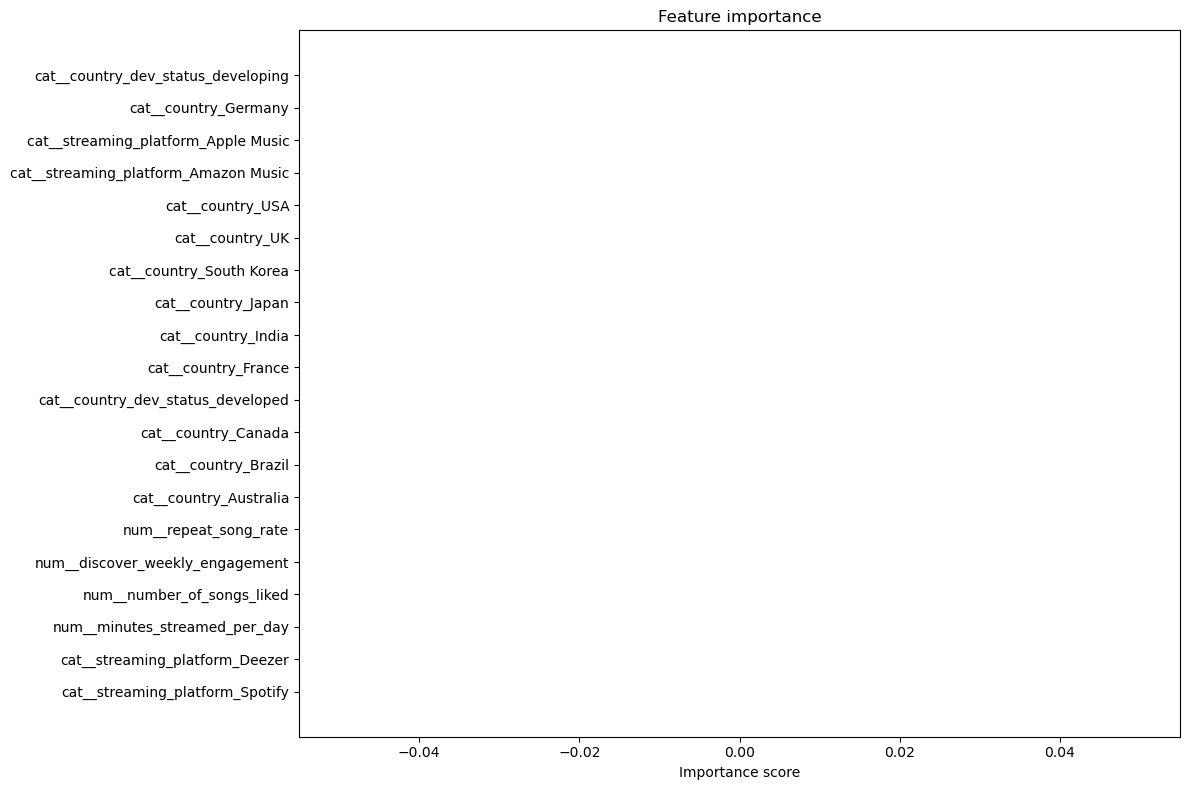


=== 优化后推荐结果 ===
推荐音乐类型: Classical
置信度: 10.0%
主要决策因素:
- age: 0.00%
- minutes_streamed_per_day: 0.00%
- number_of_songs_liked: 0.00%


In [104]:
# =================音乐推荐系统 =================
# 更新：添加了SMOTE过采样和优化决策树参数

# --------- 1. 数据准备 ---------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline  # 重要：使用imblearn的Pipeline支持SMOTE

rec_features = [
    'age', 'minutes_streamed_per_day', 'number_of_songs_liked',
    'discover_weekly_engagement', 'repeat_song_rate',
    'country', 'streaming_platform', 'most_played_artist',
    'subscription_type', 'listening_time', 'country_dev_status'
]  

rec_label = 'top_genre'

# Step 1: 选择所需列
selected_cols = rec_features + [rec_label]
sub_df = df[selected_cols].copy()

# Step 2: 处理重复列和缺失值
rec_df = sub_df.loc[:, ~sub_df.columns.duplicated()].dropna()

# 验证步骤
print("最终列名:", rec_df.columns.tolist())
assert rec_df.columns.is_unique, f"重复列: {rec_df.columns[rec_df.columns.duplicated()].tolist()}"

# --------- 2. 特征预处理 ---------
# 定义特征类型
num_all_features = [
    'age', 'minutes_streamed_per_day', 'number_of_songs_liked',
    'discover_weekly_engagement', 'repeat_song_rate'
]

cat_all_features = [
    'country', 'streaming_platform', 'most_played_artist',
    'subscription_type', 'listening_time', 'country_dev_status'
]

# 创建预处理器
rec_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_all_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_all_features)
    ],
    verbose_feature_names_out=True
)

# --------- 3. 构建推荐管道（集成SMOTE） ---------
X_rec = rec_df[rec_features]
y_rec = rec_df[rec_label]
X_train, X_test, y_train, y_test = train_test_split(X_rec, y_rec, test_size=0.2, random_state=42, stratify=y_rec)

# 创建管道 - 使用imblearn的make_pipeline支持SMOTE
rec_pipeline = make_pipeline(
    rec_preprocessor,
    SMOTE(random_state=42),  # SMOTE过采样处理类别不平衡
    DecisionTreeClassifier(
        max_depth=10,              # 增加树深度捕获更多模式
        min_samples_split=10,      # 降低分裂阈值
        min_samples_leaf=5,        # 防止过拟合的额外保护
        class_weight='balanced',   # 处理类别不平衡
        ccp_alpha=0.01,            # 代价复杂度剪枝
        random_state=42
    )
)

# 训练模型
rec_pipeline.fit(X_train, y_train)
print("模型训练成功！")

# --------- 4. 模型评估 ---------
print("\n=== 优化后模型性能评估 ===")
y_pred = rec_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

# 可视化特征重要性
import matplotlib.pyplot as plt

# 提取特征重要性
feature_names = rec_pipeline[:-1].named_steps['columntransformer'].get_feature_names_out()
feature_importances = rec_pipeline.named_steps['decisiontreeclassifier'].feature_importances_

# 创建特征重要性图表
plt.figure(figsize=(12, 8))
sorted_idx = np.argsort(feature_importances)[-20:]  # 显示最重要的20个特征
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.title("Feature importance")
plt.xlabel("Importance score")
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

# --------- 5. 推荐生成函数 ---------
def recommend_music(user_features):
    """
    输入格式示例：
    user_features = {
        'age': 25,
        'minutes_streamed_per_day': 120,
        'country': 'USA',
        'subscription_type': 'Premium',
        # ...其他特征
    }
    """
    # 转换为DataFrame
    input_df = pd.DataFrame([user_features])
    
    # 确保列顺序匹配
    input_df = input_df[rec_features]
    
    # 预处理和预测
    predicted_genre = rec_pipeline.predict(input_df)[0]
    probability = rec_pipeline.predict_proba(input_df).max()
    
    # 获取推荐依据
    feature_importance = rec_pipeline.named_steps['decisiontreeclassifier'].feature_importances_
    feature_names = rec_pipeline[:-1].named_steps['columntransformer'].get_feature_names_out()
    
    return {
        'recommended_genre': predicted_genre,
        'confidence': f"{probability:.1%}",
        'top_decision_factors': sorted(
            zip(feature_names, feature_importance),
            key=lambda x: -x[1]
        )[:3]  # 显示最重要的三个特征
    }

# --------- 6. 示例用法 ---------
if __name__ == "__main__":
    # 测试用户数据（需包含所有rec_features）
    test_user = {
        'age': 28,
        'minutes_streamed_per_day': 150,
        'number_of_songs_liked': 45,
        'discover_weekly_engagement': 70,
        'repeat_song_rate': 30,
        'country': 'USA',
        'streaming_platform': 'Spotify',
        'most_played_artist': 'Ed Sheeran',
        'subscription_type': 'Premium',
        'listening_time': 'Night',
        'country_dev_status': 'developed'
    }
    
    recommendation = recommend_music(test_user)
    print("\n=== 优化后推荐结果 ===")
    print(f"推荐音乐类型: {recommendation['recommended_genre']}")
    print(f"置信度: {recommendation['confidence']}")
    print("主要决策因素:")
    for feature, importance in recommendation['top_decision_factors']:
        print(f"- {feature.split('__')[-1]}: {importance:.2%}")